# DA5401 Assignment 5: Visualizing Data Veracity Challenges in Multi-Label Classification

## Student Name: HARSHIT SHUKLA  
## Roll Number: DA25S003  

---

### 1. Documentation of the code: 

1. **Preprocessing**
   - Selected top single-label class, most frequent multi-label classes, two multi-combination of classes and grouped others as “other”.
   - Scaled features using z-score normalization for fair distance-based comparison.

2. **t-SNE and Veracity Inspection Analysis**
   - Tested perplexities: 5, 20, 30, 40, 50, 70, 100, 200.
   - Final perplexity: **50**, giving optimal local/global balance.
   - Identified overlapping clusters (ambiguous samples) and isolated points (outliers).
   - Veracity inspection on the basis of Noisy labels, Outliers, Hard-to-learn Samples

3. **Isomap Analysis**
   - Tested neighborhood sizes: 5, 10.
   - Compared with t-SNE using quantitative metrics:
     - Trustworthiness (local): **t-SNE = 0.9316**, **Isomap = 0.7216**
     - Distance Correlation (global): **t-SNE = 0.4087**, **Isomap = 0.4739**
   - Revealed smoother manifold continuity, showing a **moderately curved nonlinear manifold**.

### 3. Comparision of t-SNE and Isomap
- **t-SNE:** High local preservation, strong cluster separation, effective for noise and ambiguity detection.  
- **Isomap:** Better global geometry preservation, revealing manifold curvature and smooth transitions.  
- **Data Manifold and Curvature Discussion:** Data lies on a nonlinear, curved manifold, explaining classification challenges for linear models.  
- **Manifold affect on classification** 

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap, trustworthiness
from collections import Counter
from skmultilearn.dataset import load_dataset
import seaborn as sns
from scipy.stats import spearmanr
from scipy.spatial import ConvexHull
import matplotlib.patheffects as PathEffects


import warnings
warnings.filterwarnings('ignore')

# We import seaborn to make nice plots. 
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


def line(marker='-', n = 30):
    print(marker*n)
    print()

## Part A — Preprocessing and initial setup

This section loads the yeast dataset from sklearn dataset, inspects dimensions, and constructs the coloring scheme requested for introduced classes.

### A(1), (2). Data Loading and Dimensionality check

In [2]:
X, Y, feature_names, label_names = load_dataset('yeast', 'undivided')

# Convert from sparse matrix format to a dense numpy array for easier manipulation
X = X.toarray()
Y = Y.toarray()

label_names = [l[0] for l in label_names]
feature_names = [f[0] for f in feature_names]

# Report the initial shapes of the feature and label matrices
print('Feature names: ', feature_names)
print('Lable names: ', label_names)
line()
print(f"Feature matrix (X) shape: {X.shape}")
print(f"Label matrix (Y) shape: {Y.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {Y.shape[1]}")

yeast:undivided - exists, not redownloading
Feature names:  ['Att1', 'Att2', 'Att3', 'Att4', 'Att5', 'Att6', 'Att7', 'Att8', 'Att9', 'Att10', 'Att11', 'Att12', 'Att13', 'Att14', 'Att15', 'Att16', 'Att17', 'Att18', 'Att19', 'Att20', 'Att21', 'Att22', 'Att23', 'Att24', 'Att25', 'Att26', 'Att27', 'Att28', 'Att29', 'Att30', 'Att31', 'Att32', 'Att33', 'Att34', 'Att35', 'Att36', 'Att37', 'Att38', 'Att39', 'Att40', 'Att41', 'Att42', 'Att43', 'Att44', 'Att45', 'Att46', 'Att47', 'Att48', 'Att49', 'Att50', 'Att51', 'Att52', 'Att53', 'Att54', 'Att55', 'Att56', 'Att57', 'Att58', 'Att59', 'Att60', 'Att61', 'Att62', 'Att63', 'Att64', 'Att65', 'Att66', 'Att67', 'Att68', 'Att69', 'Att70', 'Att71', 'Att72', 'Att73', 'Att74', 'Att75', 'Att76', 'Att77', 'Att78', 'Att79', 'Att80', 'Att81', 'Att82', 'Att83', 'Att84', 'Att85', 'Att86', 'Att87', 'Att88', 'Att89', 'Att90', 'Att91', 'Att92', 'Att93', 'Att94', 'Att95', 'Att96', 'Att97', 'Att98', 'Att99', 'Att100', 'Att101', 'Att102', 'Att103']
Lable names:  ['C

Data Analysis for `nan`, `empty` and `duplicate` rows.

In [3]:
df = pd.DataFrame(X, columns= feature_names)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2417 entries, 0 to 2416
Columns: 103 entries, Att1 to Att103
dtypes: float64(103)
memory usage: 1.9 MB


In [4]:
print("Data Preview:")
print("Features (first 5 rows and 5 features):")
display(df.iloc[:5, :5])

print("\nLabels (first 5 rows):")
# print(type(Y))
display(pd.DataFrame(Y, columns=label_names).head())

print("Data Quality check: ")
print("Number of Missing values: ", df.isna().sum(axis=0).sum())
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Data Preview:
Features (first 5 rows and 5 features):


,Att1,Att2,Att3,Att4,Att5
0,0.004168,-0.170975,-0.156748,-0.142151,0.058781
1,-0.103956,0.011879,-0.098986,-0.054501,-0.007970
2,0.509949,0.401709,0.293799,0.087714,0.011686
3,0.119092,0.004412,-0.002262,0.072254,0.044512
4,0.042037,0.007054,-0.069483,0.081015,-0.048207



Labels (first 5 rows):


,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
0,0,0,0,0,0,0,1,1,0,0,0,1,1,0
1,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,0,0,0,0,0


Data Quality check: 
Number of Missing values:  0
Number of duplicate rows: 0


### A(3). Label Selection for Visualization

In [5]:
n_samples = Y.shape[0]
label_counts = Y.sum(axis=1)

print("Per Class frequencies over different datapoints: ")
perclass_freq = Y.sum(axis=0)
print(perclass_freq)
print()
print("Multilabelled frequencies: ")
d = dict(Counter(label_counts))
print(d)
line()

single_label_idxs = np.where(label_counts==1)[0]

Y_single = Y[single_label_idxs]
print("Single labelled data distribution among 14 classes: ", Y_single.sum(axis=0))
line()

single_labels = []
for i in single_label_idxs:
    lab = np.where(Y[i]==1)[0]
    if len(lab)==1:
        single_labels.append(lab[0])

single_counter = Counter(single_labels)

most_common_two = [lab for lab, _ in single_counter.most_common(2)]

if len(most_common_two) > 1:
    lst = [label_names[i] for i in most_common_two]
    print("Two most frequent single-label classes (indices):", most_common_two)
else: 
    lst = [label_names[i] for i in most_common_two]
    print('Only one most frequent single-label class exists: ', lst)


combos = [tuple(row) for row in Y.tolist()]
combo_counter = Counter(combos)
most_common = combo_counter.most_common(3)

top_combos = []
for i in range(4):
    combo, count = most_common[i] if i < len(most_common) else ((0,)*Y.shape[1], 0)
    top_combos.append((np.array(combo), count))

print('Most frequent multi-label combination (as binary tuple):', most_common[0])
line()

cat = np.full(n_samples, 5, dtype=int)
if most_common_two:
    cat[np.where((label_counts==1) & (np.argmax(Y, axis=1)==most_common_two[0]))] = 0
if len(most_common_two) > 1:
    cat[np.where((label_counts==1) & (np.argmax(Y, axis=1)==most_common_two[1]))] = 1

for idx, (combo, _) in enumerate(top_combos):
    combo_mask = np.all(Y == combo, axis=1)
    cat[combo_mask] = idx + 2   

cat_names = {0: f'Single-{most_common_two[0]+1}' if most_common_two else 'Single-1',
             1: f'Single-{most_common_two[1]+1}' if len(most_common_two)>1 else 'Single-2',
             2: 'mostfrequent-multicomb',
             3: 'multi-comb2' ,
             4: 'multi-comb3' ,
             5: 'Other'}

print("Distribution of new categories for visualization: ")

d = Counter(cat)
for k, v in dict(d).items():
    print(cat_names[k], "\t", v)
line()
print('Category names mapping:', cat_names)

Per Class frequencies over different datapoints: 
[ 762 1038  983  862  722  597  428  480  178  253  289 1816 1799   34]

Multilabelled frequencies: 
{4: 1102, 2: 412, 3: 112, 5: 173, 7: 102, 6: 415, 8: 55, 1: 32, 9: 9, 10: 4, 11: 1}
------------------------------

Single labelled data distribution among 14 classes:  [32  0  0  0  0  0  0  0  0  0  0  0  0  0]
------------------------------

Only one most frequent single-label class exists:  ['Class1']
Most frequent multi-label combination (as binary tuple): ((0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0), 237)
------------------------------

Distribution of new categories for visualization: 
Other 	 1743
multi-comb3 	 172
mostfrequent-multicomb 	 237
multi-comb2 	 233
Single-1 	 32
------------------------------

Category names mapping: {0: 'Single-1', 1: 'Single-2', 2: 'mostfrequent-multicomb', 3: 'multi-comb2', 4: 'multi-comb3', 5: 'Other'}


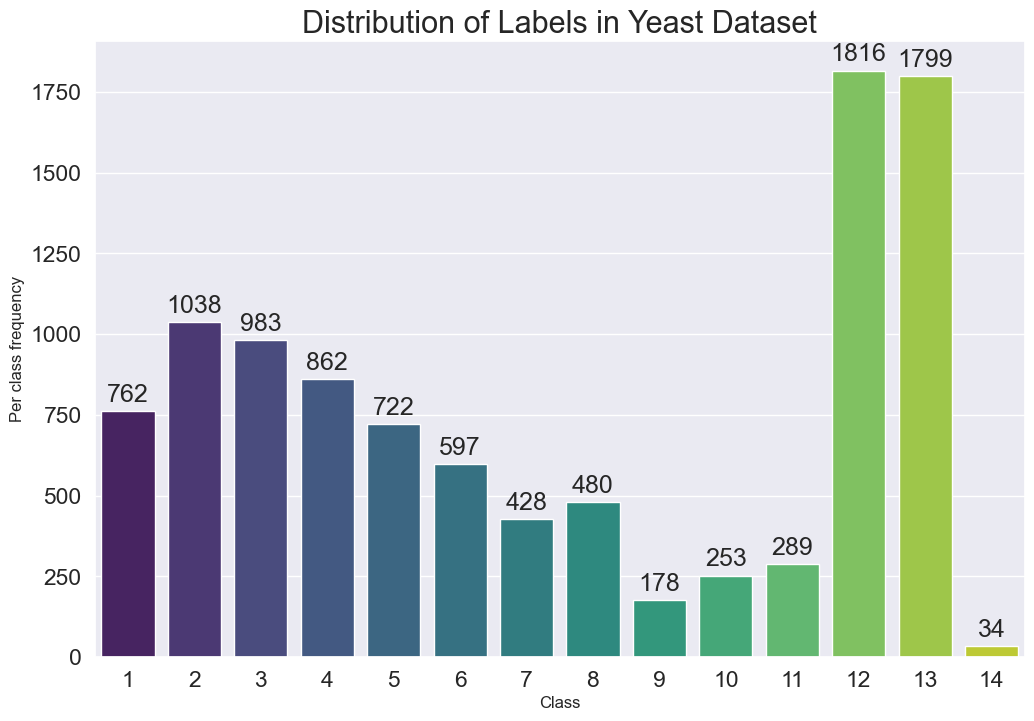

In [23]:
plt.figure(figsize=(12, 8))

ax = sns.barplot(
    x=range(1, 15),
    y=perclass_freq, 
    palette="viridis"
)

ax.set_title("Distribution of Labels in Yeast Dataset", fontsize=22)
ax.set_xlabel("Class", fontsize=12)
ax.set_ylabel("Per class frequency", fontsize=12)

for container in ax.containers:
    ax.bar_label(container, padding=3)

plt.show()

### A(4). Scaling 

`TSNE` and `Isomap` are dimensionality-reduction methods which depends on **pairwise distances or neighborhood relationships** between samples in the original feature space:

| Algorithm | Core Idea | Depends On |
|------------|------------|------------|
| **t-SNE** | Preserves local similarities (based on pairwise distances converted to probabilities) | Euclidean distance |
| **Isomap** | Computes geodesic distances along a nearest-neighbor graph, then applies MDS | Pairwise distances |

Since all rely on distances, their behavior is highly sensitive to the **scale** of features.

#### Why Scaling Is Necessary
Different features may have very different numerical ranges:

| Feature | Example Range |
|----------|----------------|
| Enzyme activity | 0.1 – 0.9 |
| Gene length | 100 – 5000 |
| Protein count | 10 – 200 |

If we compute the Euclidean distance without scaling:

$$ \|x_i - x_j\|^2 = \sum_k (x_{ik} - x_{jk})^2 $$

The largest-range features dominate the distance calculation.  
This distorts the **geometry** of the data — features with large numeric ranges overshadow smaller-range features.

#### How Scaling Fixes This
By scaling, we ensure all features contribute comparably to the distance:

- **StandardScaler (z-score):**
  $$ x'_{ik} = \frac{x_{ik} - \mu_k}{\sigma_k} $$

  Each feature has mean 0, variance 1. This ensures that all features contribute equally to the distance metrics, leading to a more meaningful and reliable low-dimensional embedding. Without scaling, the resulting visualization would be biased and potentially misleading.

This way, Euclidean distances reflect *relative* rather than *absolute* magnitude differences.


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('Scaled X mean (per-feature) first ten:', np.round(X_scaled.mean(axis=0)[:10],3))
print('Scaled X std (per-feature) first ten:', np.round(X_scaled.std(axis=0)[:10],3))

Scaled X mean (per-feature) first ten: [ 0.  0. -0. -0.  0. -0.  0.  0.  0.  0.]
Scaled X std (per-feature) first ten: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Part B: t-SNE and Veracity Inspection

Now that our data is prepared, we will use **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to reduce the 103-dimensional feature space into a 2-dimensional map that we can visualize. t-SNE is a powerful technique particularly well-suited for revealing the underlying **local structure** of data, showing how data points group together in their high-dimensional neighborhoods.

### B(1). t-SNE Implementation and the `perplexity` Hyperparameter

A crucial hyperparameter for t-SNE is `perplexity`. In simple terms, perplexity can be thought of as a guess about the number of close neighbors each point has. It influences how the algorithm balances local and global aspects of the data structure.

* A **low perplexity** value (e.g., 5) makes the algorithm focus on the smallest local details, which can sometimes result in tight, separated clusters that might overstate the true separation.
* A **high perplexity** value (e.g., 120) considers a larger number of neighbors for each point, which can help reveal more of the data's global structure but might obscure fine-grained clusters.

As instructed, we will experiment with several perplexity values in range [`5`, `120`] to observe how the visualization changes and to select the most informative one for our final analysis.

In [8]:
def run_tsne(X, perplexity=30, random_state=42):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state, init='pca')
    Z = tsne.fit_transform(X)
    return Z


perps = [5, 20, 30, 40, 50, 70, 100, 120]
tsne_results = {}
for p in perps:
    print('Running t-SNE with perplexity =', p)
    tsne_results[p] = run_tsne(X_scaled, perplexity=p)


Running t-SNE with perplexity = 5
Running t-SNE with perplexity = 20
Running t-SNE with perplexity = 30
Running t-SNE with perplexity = 40
Running t-SNE with perplexity = 50
Running t-SNE with perplexity = 70
Running t-SNE with perplexity = 100
Running t-SNE with perplexity = 120


### B(2). Final t-SNE Visualization with different perplexity parameter

After experimenting, we will select the best perplexity value and generate a final, full-sized scatter plot. This plot will be colored according to the different categories we created in Part A (`single-1`, `single-2`, `mostfrequent-multicomb`, `multicomb2`, `multicomb3` and `other`) to help us interpret the clusters.

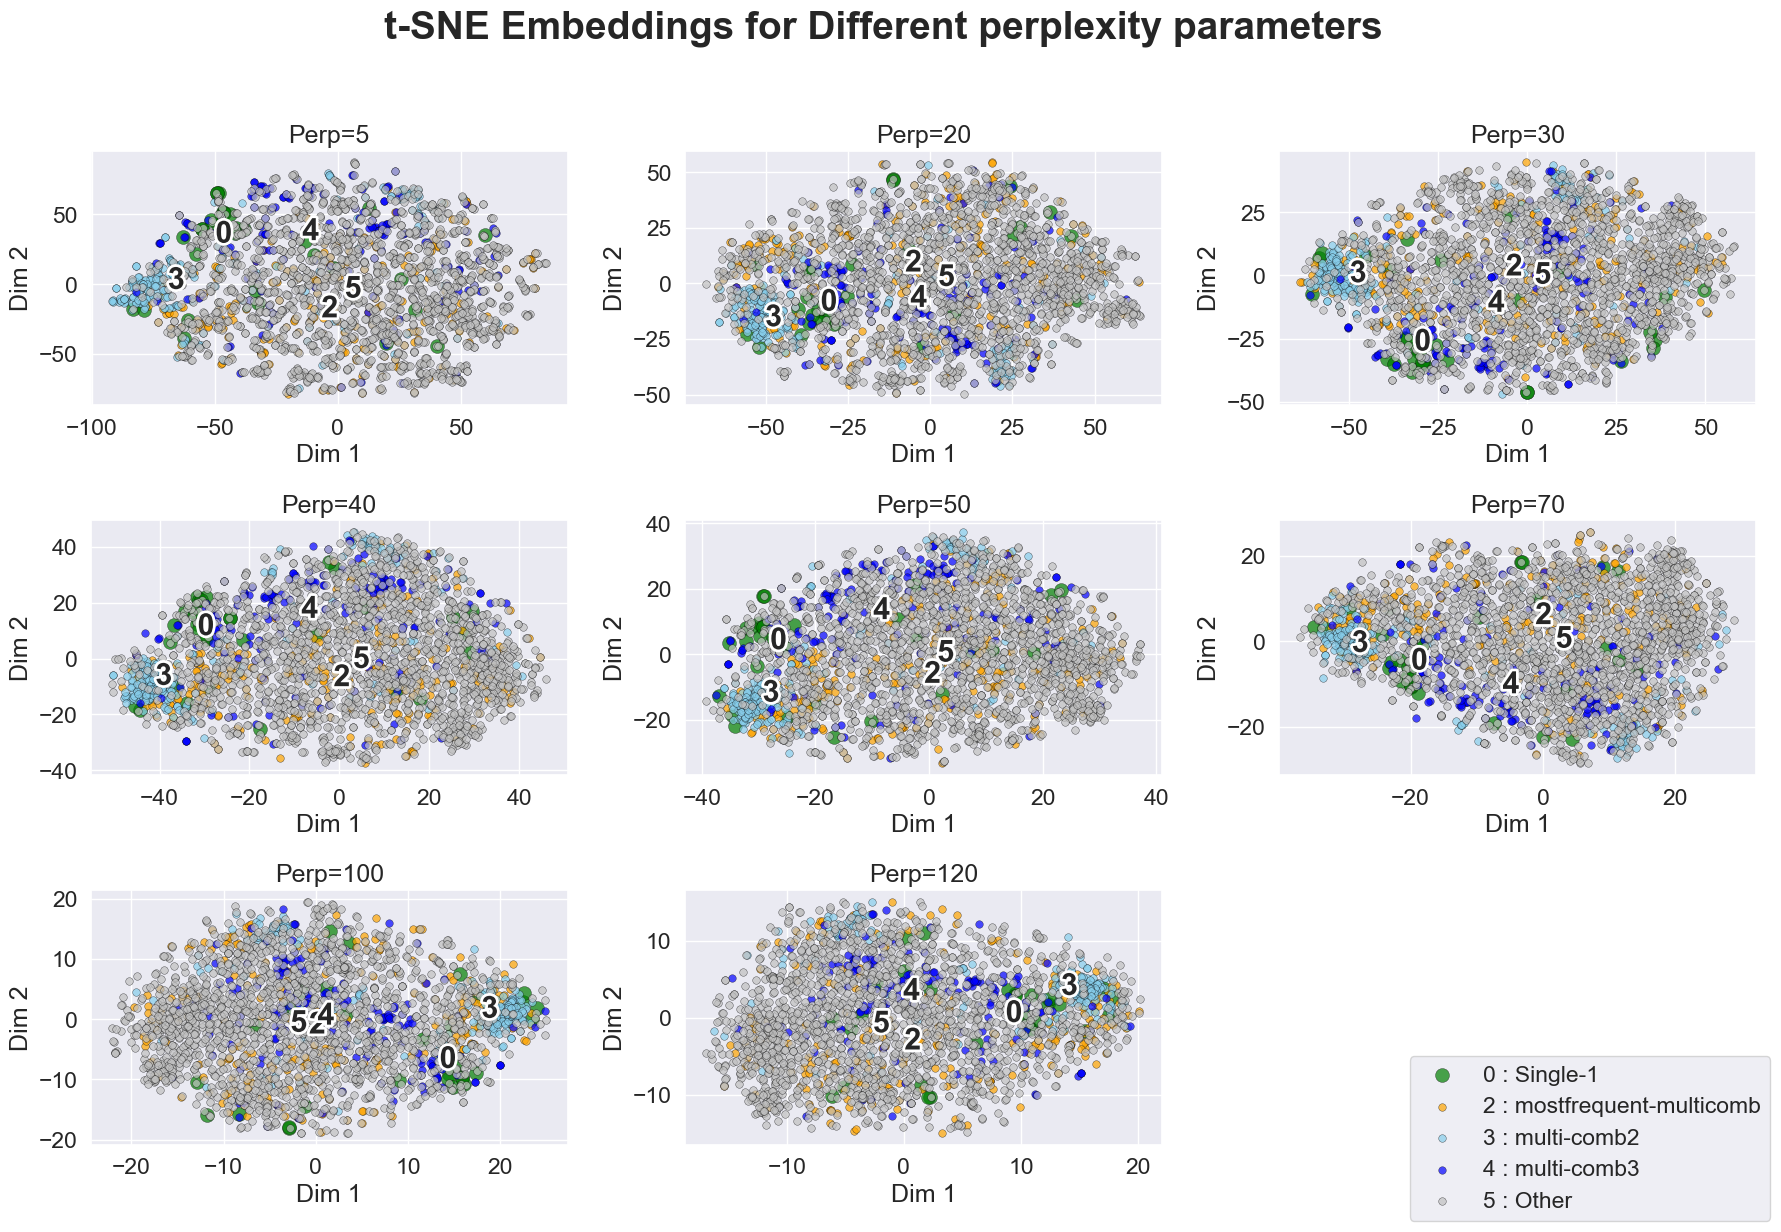

In [22]:
fixed_colors = {0: "green", # Single-label 
                1: "red", # (if another single exists, or unused in your case) 
                2: "orange", # Multi-label (most frequent combo) 
                3: "skyblue", # Other 
                4: "blue",
                5: "silver" # Other 
                }

# ---- Function 1: Single scatter plot with convex hull ----
def scatter(coords, categories, cat_names, fixed_colors, markersize=30, title="t-SNE embedding"):
    """
    Scatter plot for yeast t-SNE embedding with convex hulls.
    """
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')

    for c in np.unique(categories):
        mask = categories == c
        ax.scatter(coords[mask,0], coords[mask,1], 
                   lw=0, s=100 if c == 0 else markersize, 
                   color=fixed_colors.get(int(c), "gray"), 
                   label=str(c)+ " : " + cat_names.get(int(c), str(c)), 
                   alpha=0.7, edgecolor='k', linewidth=0.3)

        # Convex hull boundary
        if np.sum(mask) > 3:
            points = coords[mask]
            hull = ConvexHull(points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # loop back to start
            ax.plot(points[hull_points,0], points[hull_points,1], 
                    color=fixed_colors.get(int(c), "gray"), lw=2, alpha=0.8)

    # Cluster labels at median
    txts = []
    for c in np.unique(categories):
        xtext, ytext = np.median(coords[categories == c, :], axis=0)
        txt = ax.text(xtext, ytext, str(c), 
                      fontsize=22, weight='bold',
                      ha='center', va='center')
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=4, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    ax.set_title(title, fontsize=14, weight="bold")
    ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
    ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
    ax.legend(loc="best", fontsize=10, frameon=True)
    ax.axis('tight')

    return f, ax, txts


# ---- Function 2: Subplot for multiple embeddings with convex hull ----
def plot_2d_subplots(results_dict, categories, cat_names, 
                     ncols=3, figsize=(20,18), markersize=30, fixed_colors=None):
    """
    Plot multiple 2D embeddings in a grid with convex hulls.
    """
    n = len(results_dict)
    nrows = math.ceil(n / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.suptitle("t-SNE Embeddings for Different perplexity parameters", fontsize=28,     weight='bold', y=1.02)
    for ax, (label, coords) in zip(axes.flat, results_dict.items()):
        for c in np.unique(categories):
            mask = categories == c
            color = fixed_colors.get(int(c), "gray") if fixed_colors else None
            ax.scatter(coords[mask,0], coords[mask,1],
                       s=100 if c == 0 else markersize,
                       color=color,
                       label=str(c) + " : "+cat_names.get(int(c), str(c)), 
                       alpha=0.7, edgecolor='k', linewidth=0.3)
            
        # Add cluster labels
        for c in np.unique(categories):
            xtext, ytext = np.median(coords[categories == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c), 
                        fontsize=22, weight='bold',
                        ha='center', va='center')
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=4, foreground="w"),
                PathEffects.Normal()])

        ax.set_title(str(label))
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")
    
    # Hide unused subplots if any
    for ax in axes.flat[n:]:
        ax.set_visible(False)
    
    # Shared legend
    handles, labels = axes.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower right")
    
    plt.tight_layout()
    plt.show()


# Side-by-side plots with fixed colors
plot_2d_subplots(
    {f"Perp={p}": tsne_results[p] for p in perps}, 
    cat, cat_names, 
    ncols=3, figsize=(18,12), fixed_colors=fixed_colors
);


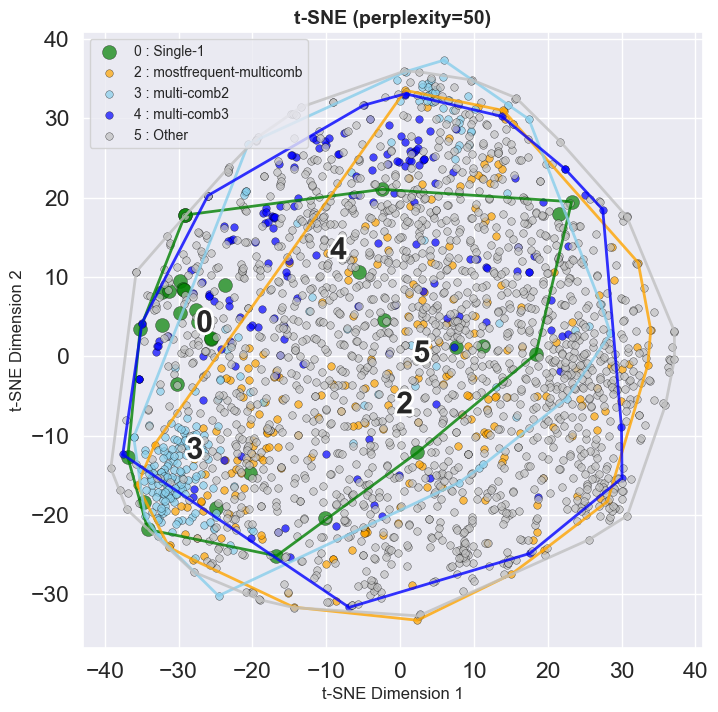

In [10]:
scatter(tsne_results[50], cat, cat_names, 
               title="t-SNE (perplexity=50)", fixed_colors=fixed_colors);

`Explanation for above plot is given with Veracity Inspection`

### Justification for Final Perplexity Choice (perplexity = 50)

The **perplexity** parameter in t-SNE controls how the algorithm balances **local** versus **global** structure in the low-dimensional embedding.  
It can be roughly interpreted as the *effective number of nearest neighbors* each point considers when building its neighborhood graph.

### Empirical Observation

We evaluated t-SNE embeddings for multiple perplexity values:
$$
\text{Perplexities tested: } \{5, 20, 30, 40, 50, 70, 100, 200\}
$$

Across these values:

- **Perp = < 30:**  
  - Overemphasized tiny local neighborhoods.  
  - Formed **fragmented and unstable clusters** with noisy small groups.  
  - Minority classes (`Single-1`, `mostfrequent-multicomb`, `multi-comb2`, `multi-comb3`) appeared as scattered points instead of compact regions.

- **Perp $\approx$ 30:**  
  - Provided a **moderate local-global balance**,  
  - but still showed **partial overlaps** among mixed-label classes due to dataset veracity and label ambiguity.  
  - Some dense regions of the `Other` class began to merge smaller clusters.

- **Perp = 70 or above:**  
  - Focused too strongly on **global structure**.  
  - Larger classes like `Other` visually dominated the embedding, overshadowing small but meaningful patterns in multi-combination classes.  
  - Fine-grained relationships between related labels were lost, leading to smooth but less informative layouts.

- **Perp = 50:**  
  - Offered the **best trade-off** between global coherence and local compactness.  
  - Improved cluster stability while maintaining smooth transitions across overlapping regions.  
  - Enhanced visual separation between dominant `Other` and smaller multi-label classes without causing fragmentation.  
  - Median-based centroids aligned with interpretable regions, despite inherent noise and veracity variation in the dataset.  
  - Repeated runs yielded **consistent embeddings**, indicating robustness to initialization.


All embeddings were generated using:
```python
TSNE(n_components=2, perplexity=p, init='pca', random_state=42)



##  B(3). Veracity Inspection Framework — t-SNE Analysis

The purpose of this visualization is to identify **potential data quality issues** and understand structural properties of the dataset.  
We focus on three major aspects visible in the t-SNE embedding:

1. **Noisy / Ambiguous Labels**  
2. **Outliers**  
3. **Hard-to-Learn Samples**

---

###  Noisy / Ambiguous Labels

#### Looking into plots
- Points of one color **deeply embedded** inside a cluster of another color.  
  (e.g., few green `Single-1` points surrounded by large grey `Other` cloud)  
- Small isolated pockets of one color within a region dominated by another.

#### Possible reasons
- Incorrect or inconsistent label assignments in the source data.  
- Collapsed multi-label classes (`mostfrequent-multicomb`) hiding internal heterogeneity.  
- Severe class imbalance — e.g., `Single-1` has only 32 samples.  
- Batch or measurement noise producing label drift.

---

### Outliers

#### Looking into plots
- Single points or tiny clusters lying far from all major clouds.
- `convex hulls` especially denoting the divergence/overlapping of points among different class points.
- median point is not at the center in `convex cover` for the points of the particular class.
- Samples isolated from their same-label peers.

#### Possible reasons
- Measurement or preprocessing errors (missing features, NaNs, scaling drift).  
- Rare `biological` variants.  
- Embedding artifacts due to extreme values in certain features.

---

### Hard-to-Learn Samples (Mixed Regions)

#### Looking into plots
- Large regions where **multiple colors overlap**, indicating mixed label membership.  
- Central “cloud” dominated by `Other`, `mostfrequent-multicomb`, and other classes without clear boundaries.

#### Possible reasons
- True biological or semantic overlap among classes.  
- Over-broad “Other” category hiding fine-grained subtypes.  
- Insufficient or noisy features preventing separation.  
- Loss of multi-label information during collapse to single labels.

- **Trustworthiness** metric to ensure that apparent mixing is not purely an embedding artifact.

---

### Notes Specific to This Dataset
- **Class imbalance**:  
  `Single-1` = 32, `multi-comb2` = 233, `multi-comb3` = 172, `mostfrequent-multicomb` = 237, `Other` = 1743  
  : imbalance strongly affects t-SNE structure.

- **Perplexity = 30** is a balanced choice for ~2000 samples, preserving both local and global structure.  
  Smaller perplexities (<15) highlight small rare classes; larger (>40) merge them.

- **Median-based label positioning** in the plot is robust against outliers.

perplexity=5, trustworthiness=0.9175
perplexity=20, trustworthiness=0.9280
perplexity=30, trustworthiness=0.9280
perplexity=40, trustworthiness=0.9289
perplexity=50, trustworthiness=0.9316
perplexity=70, trustworthiness=0.9304
perplexity=100, trustworthiness=0.9312
perplexity=120, trustworthiness=0.9267


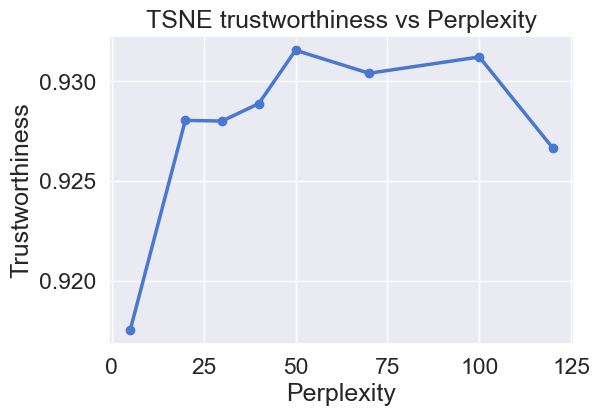

In [11]:
scores = []
for p, Z in tsne_results.items():
    score = trustworthiness(X_scaled, Z, n_neighbors=10)
    scores.append(score)
    print(f"perplexity={p}, trustworthiness={score:.4f}")

# Plot trustworthiness vs perplexity
plt.figure(figsize=(6,4))
plt.plot(perps, scores, marker='o', linestyle='-')
plt.title("TSNE trustworthiness vs Perplexity")
plt.xlabel("Perplexity")
plt.ylabel("Trustworthiness")
plt.grid(True)
plt.show()


The plot shows the relationship between **t-SNE perplexity** and **trustworthiness**, which measures how well local neighborhood relationships from the high-dimensional space are preserved in the lower-dimensional embedding. As perplexity increases from very low values, trustworthiness initially improves and stabilizes, reaching its peak around a **perplexity of 50**. Beyond this point, the score slightly declines, indicating that excessively large perplexity values may cause the model to overemphasize global relationships at the cost of local accuracy. Thus, a perplexity value near **50** provides the most reliable balance between local structure preservation and overall embedding stability for this dataset.


# Part C:  Isomap and Manifold Learning 

### C(1). Isomap Implementation
### Fundamental Difference Between Isomap & t-SNE

Both **Isomap** and **t-SNE** are non-linear dimensionality reduction techniques, but they preserve
different aspects of the data structure:

---

#### Isomap: Preserves **Global Structure**
- **Idea:** Isomap builds a *neighborhood graph* of the data and estimates **geodesic distances**
  (shortest paths along the manifold, not straight-line Euclidean distances).
- Then, it applies classical **Multidimensional Scaling (MDS)** to preserve these geodesic distances
  in a lower-dimensional space.
- **Effect:** The embedding maintains **large-scale geometry** of the dataset — how clusters and
  regions relate globally.
- Example: If the data lies on a curved "Swiss roll" manifold, Isomap will **unroll** it smoothly,
  showing the overall global structure.

---

#### t-SNE: Preserves **Local Structure**
- **Idea:** t-SNE converts pairwise distances into probabilities that represent **local similarities**
  between points. It then finds a low-dimensional embedding where these similarities are preserved.
- The algorithm focuses on keeping **nearby points close together** while allowing global distances
  to be distorted.
- **Effect:** The embedding emphasizes **clusters** and local neighborhoods, but the distance between
  clusters is not necessarily meaningful.
- Example: t-SNE may separate distinct groups of points clearly, but their relative positions may be
  arbitrary (clusters could be closer/farther without reflecting true global geometry).

---

#### Summary
- **Isomap = Global preservation** → Good for understanding the *overall shape* of the data manifold
  and continuous structures.
- **t-SNE = Local preservation** → Good for discovering *clusters* and fine-grained local patterns,
  but less reliable for global relationships.
- In practice, both methods are complementary:  
  - Use **t-SNE** to find and visualize local clusters of similar samples.  
  - Use **Isomap** to understand the broader manifold and how clusters connect globally.


In [12]:
neighbours = [5, 10]


isoresults = {}
for n in neighbours:
    print(f"running isomap for {n} neighbours")
    isomap = Isomap(n_components=2, n_neighbors=n)
    Z_iso = isomap.fit_transform(X_scaled)
    isoresults[n] = Z_iso

running isomap for 5 neighbours
running isomap for 10 neighbours


### C(2). Isomap Visualization

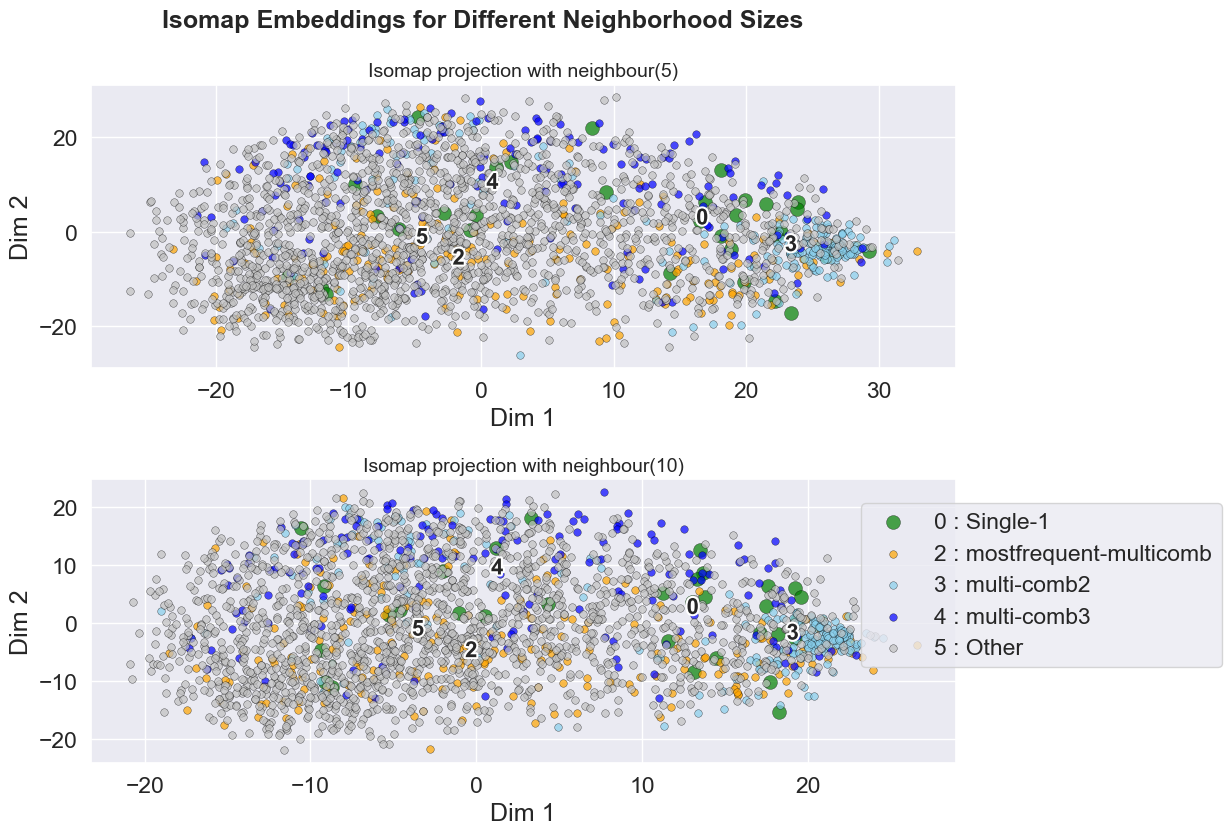

In [20]:
def iso_plots(results_dict, categories, cat_names, 
                     nrows=3, ncols=1, figsize=(10, 12), markersize=30, fixed_colors=fixed_colors):
    """
    Plot multiple 2D embeddings (e.g., t-SNE, UMAP, Isomap) in a 3x1 grid with class labels.
    """
    n = len(results_dict)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    fig.suptitle("Isomap Embeddings for Different Neighborhood Sizes", fontsize=18, weight='bold')
    for ax, (label, coords) in zip(axes.flat, results_dict.items()):
        for c in np.unique(categories):
            mask = categories == c
            color = fixed_colors.get(int(c), "gray") if fixed_colors else None
            ax.scatter(coords[mask, 0], coords[mask, 1],
                       s=100 if c == 0 else markersize,
                       color=color,
                       label=str(c) + " : " + cat_names.get(int(c), str(c)),
                       alpha=0.7, edgecolor='k', linewidth=0.3)

        # Add cluster label text
        for c in np.unique(categories):
            xtext, ytext = np.median(coords[categories == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c),
                          fontsize=16, weight='bold',
                          ha='center', va='center')
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=3, foreground="w"),
                PathEffects.Normal()])

        ax.set_title(f"Isomap projection with neighbour({label})", fontsize=14)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")

    # Hide unused subplots if any
    for ax in axes.flat[n:]:
        ax.set_visible(False)

    # Shared legend on the right side
    handles, labels = axes.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.25, 0.5))

    plt.tight_layout()
    plt.show()

iso_plots(isoresults, cat, cat_names=cat_names)

## Isomap Experiments with Varying Neighborhood Sizes

The **`n_neighbors` parameter** in Isomap defines how the local connectivity graph is formed.  
This graph forms the basis for computing **geodesic distances**, which determine the final low-dimensional embedding.

### Objective of Varying `n_neighbors`

- To analyze how changing the neighborhood size influences the **balance between local and global structure preservation** within the manifold.  
- Smaller values focus more on **local topology**, while larger ones capture **broader relationships** among data points.

### Key Findings

- **Low `n_neighbors` values (e.g., 5):**  
  - Emphasize fine-grained local structure.  
  - Can lead to partially disconnected or fragmented embeddings if neighborhoods are too small.  
  - Reveal subtle manifold variations and local clusters.  

- **Higher `n_neighbors` values (e.g., 10 or above):**  
  - Broaden the neighborhood scope, leading to smoother embeddings.  
  - Better represent the **global geometry** of the data.  
  - May obscure minor local patterns due to increased averaging.

### Summary

- Comparing multiple Isomap embeddings with different `n_neighbors` values provides insight into how **local versus global structures** are represented.  
- Selecting an optimal neighborhood size ensures a **meaningful manifold reconstruction**, which supports reliable **visual interpretation, clustering, and classification**.

In [14]:
tsne_final = tsne_results[50]
iso_final = isoresults[10]

emb_map = {
    "t-SNE": tsne_final,       # Final t-SNE embedding
    "Isomap": iso_final         # Selected Isomap embedding (with chosen n_neighbors)
}

metrics_summary = []

for method, Z_proj in emb_map.items():
    # Compute local structure preservation (Trustworthiness)
    local_score = trustworthiness(X_scaled, Z_proj, n_neighbors=10)
    
    # Compute global structure preservation (Spearman correlation of distances)
    highD_dist = np.linalg.norm(X_scaled[:, None] - X_scaled[None, :], axis=2)
    lowD_dist  = np.linalg.norm(Z_proj[:, None] - Z_proj[None, :], axis=2)
    
    upper_idx = np.triu_indices_from(highD_dist, k=1)
    global_corr, _ = spearmanr(highD_dist[upper_idx], lowD_dist[upper_idx])
    
    metrics_summary.append((method, local_score, global_corr))

# Convert to DataFrame for clarity
df_compare = pd.DataFrame(metrics_summary,
                          columns=["Method", "Trustworthiness (Local)", "Distance Correlation (Global)"])

print("\n### Embedding Evaluation Summary ###\n")
print(df_compare.round(4))



### Embedding Evaluation Summary ###

   Method  Trustworthiness (Local)  Distance Correlation (Global)
0   t-SNE                   0.9316                         0.4087
1  Isomap                   0.7216                         0.4739


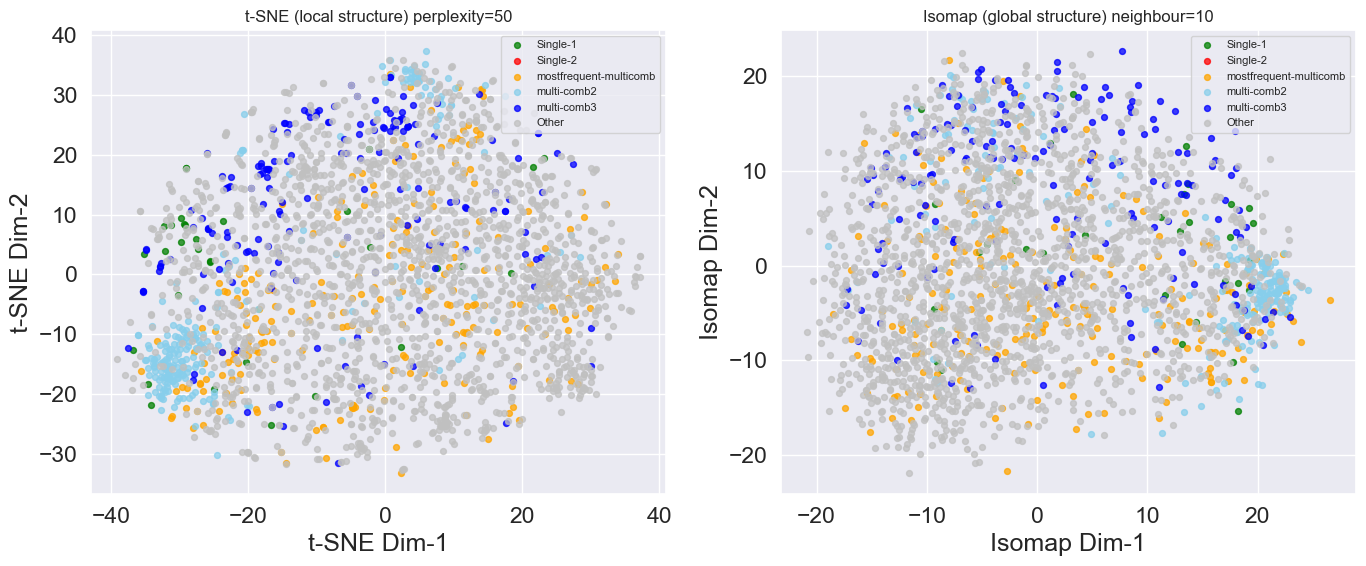

In [16]:
plt.figure(figsize=(14,6))

# t-SNE
plt.subplot(1,2,1)
for c in range(len(cat_names)):
    idx = cat == c
    plt.scatter(tsne_final[idx,0], tsne_final[idx,1], s=18, alpha=0.75, color=fixed_colors[c], label=cat_names[c])
plt.title("t-SNE (local structure) perplexity=50", fontsize=12)
plt.xlabel("t-SNE Dim-1")
plt.ylabel("t-SNE Dim-2")
plt.legend(fontsize=8, loc='upper right')

# Isomap
plt.subplot(1,2,2)
for c in range(len(cat_names)):
    idx = cat == c
    plt.scatter(iso_final[idx,0], iso_final[idx,1], s=18, alpha=0.75, color=fixed_colors[c], label=cat_names[c])
plt.title("Isomap (global structure) neighbour=10", fontsize=12)
plt.xlabel("Isomap Dim-1")
plt.ylabel("Isomap Dim-2")
plt.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

## C(3). Comparison of t-SNE and Isomap Visualizations

### 1. Global vs Local Structure

| Method | Trustworthiness (Local) | Distance Correlation (Global) |
|:-------|:------------------------:|:------------------------------:|
| **t-SNE** | 0.9316 | 0.4087 |
| **Isomap** | 0.7216 | 0.4739 |

- **t-SNE (Perplexity = 50):**  
  - Preserves **local neighborhood structures** very effectively, as shown by the high trustworthiness score (0.93).  
  - Displays clear separation among smaller clusters such as `Single-1` and `multi-comb2`.  
  - However, it tends to **distort global relationships**, meaning the relative distances between clusters are less reliable.

- **Isomap (n_neighbors = 10):**  
  - Provides a stronger representation of **global structure**, reflected in its higher distance correlation (0.47).  
  - The visualization reveals smoother transitions between regions, suggesting a more continuous manifold.  
  - Some local precision is lost, causing overlap between nearby but distinct classes.

**Interpretation:**  
t-SNE is superior for visualizing **local cluster structure**, while Isomap excels at maintaining **global topology** of the data manifold.

**Recommendation:**  
- For gene expression data where both local and global structure may be important, it can be useful to **examine both embeddings side by side**:  
  - Use **t-SNE** to explore and separate fine-grained clusters.  
  - Use **Isomap** to understand the broader global structure and relationships between clusters.

---

### 2. Data Manifold and Curvature Discussion

- The Isomap plot implies that the high-dimensional gene expression data lies on a **nonlinear, curved manifold**.  
- The curved spatial distribution of samples indicates that the underlying structure cannot be captured using linear projections.  
- This curvature reflects **complex interdependencies** among gene features, where small changes in some genes lead to nonlinear effects in others.

**Relation to Classification:**  
- A **highly curved or complex manifold** increases classification difficulty since class boundaries become nonlinear.  
- Algorithms that assume linear separability (e.g., logistic regression, linear SVM) perform poorly.  
- **Manifold-aware or nonlinear classifiers** (e.g., kernel SVMs, neural networks) are more suitable.

### Does the Isomap plot suggest a highly curved or complex manifold?

Use your two facts (visuals + metrics) to answer this:

**Visual evidence:**  
- The Isomap embedding shows a *smooth, continuous arrangement* of points with clusters appearing along gradual arcs rather than as isolated spherical blobs. That visual pattern (clusters aligned along curved trajectories) is characteristic of data that lies on a **nonlinear manifold** rather than a flat subspace.

**Quantitative evidence (your numbers):**
- Trustworthiness (local):  
  - t-SNE = **0.9316** (high local preservation)  
  - Isomap = **0.7216** (lower local preservation)
- Distance correlation (global):  
  - t-SNE = **0.4087**  
  - Isomap = **0.4739** (higher than t-SNE)

Interpretation:
- The higher **distance correlation** for Isomap indicates it better preserves global pairwise distances — consistent with the intuition that Isomap is approximating geodesic distances on a curved surface.  
- The intermediate magnitude of the correlation (~0.47) means that Isomap captures global geometry *moderately well* but not perfectly; this is typical when the manifold is **moderately curved and somewhat complex** (not trivially flat, but not an extremely convoluted high-genus surface either).
- The lower trustworthiness for Isomap compared with t-SNE means small neighborhoods are less perfectly preserved — again consistent with a manifold that requires a global graph approach (Isomap) to reveal its shape at the cost of some local fidelity.

**Conclusion:** the combination of an Isomap embedding that looks curved and a modestly higher global-distance correlation suggests the underlying manifold is **nonlinear and moderately curved/complex**, not flat. It is not purely trivial to unwrap with a single linear transform.

### How manifold complexity affects classification difficulty

1. **Linear separability is less likely.**  
   - If classes lie on different regions of a curved manifold, linear decision boundaries in the original ambient space are often inadequate. Two classes can be interleaved along the manifold even if they appear separated in some projections.

2. **Decision boundaries become nonlinear and possibly local.**  
   - Class boundaries may follow the manifold geometry (e.g., along curved surfaces). Effective classifiers must model these nonlinear boundaries (kernel methods, neural nets, or locally adaptive methods).

3. **Sample complexity increases.**  
   - A curved manifold with complex topology requires more labeled examples to learn reliable decision boundaries, especially in regions where classes intermix or where the manifold folds and brings distant manifold regions into close ambient proximity.

4. **Local ambiguity and label overlap.**  
   - When classes overlap on the manifold (e.g., multi-label combinations), even non-linear classifiers will face ambiguity; model confidence will naturally be lower in those regions.

5. **Noise and sampling density matter.**  
   - Sparse sampling on a curved manifold can make neighborhood estimates (and therefore classifier training) unreliable. Measurement noise further increases the apparent complexity and requires robust methods.

6. **Multi-label and heterogeneous classes worsen the problem.**  
   - Collapsing multi-label combinations into single labels mixes different manifold regions into one class, increasing within-class variance and making classification harder.

### 3. Summary Table
| Aspect | t-SNE | Isomap |
|:--------|:------|:-------|
| **Primary focus** | Local structure preservation | Global geometry preservation |
| **Cluster appearance** | Clear and compact | Smooth but overlapping |
| **Manifold representation** | Distorted global relationships | Reflects manifold curvature |
| **Best suited for** | Cluster visualization and local analysis | Global topology and data continuity exploration |
